# МОДУЛЬ 14. ПРАКТИКА 14.6 (HW-03)

1. Написать линейную модель при помощи библиотеки sklearn. Для векторизации текста использовать TfidfVectorizer, а в качестве модели — LogisticRegression.
2. Предсказать классы на тестовом сете и посчитать accuracy.
3. Использовать модели LinearSVM. Сравнить с логистической регрессией.
4. Использовать N-грамму в своём TF-IDF с параметром max_features (хорошее число 50 000) — при большом количестве фичей модель может начать переобучаться.

## Библиотеки

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import datasets
import tokenizers
import wandb
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [22]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [52]:
from sklearn import metrics
from sklearn.metrics import classification_report

## Исходный набор данных

IMDB - это датасет по классификации эмоциональной окраски. Вам нужно предсказать положительный ли отзыв к фильму по его тексту. Это довольно простая задача и она хорошо решается даже линейными моделями. Для доступа к нему мы используем библиотеку datasets - она содержит в себе много интересных текстовых датасетов.

Тренировочная и тстовая части IMDB достаточно большие - каждая состоит из 25 тысяч примеров.

In [2]:
text_dataset = datasets.load_dataset("imdb")

Reusing dataset imdb (C:\Users\Nata\.cache\huggingface\datasets\imdb\plain_text\1.0.0\2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
text_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Как мы видим, классы сбалансированны, что позволяет использовать accuracy как простую и интерпретируемую метрику, хорошо показывающую качество модели.

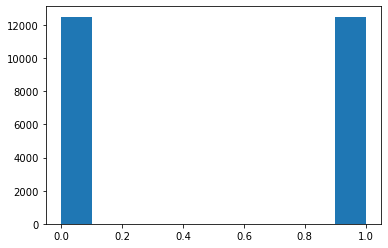

In [11]:
train_labels = [e['label'] for e in text_dataset['train']]
plt.hist(train_labels)
plt.show()

In [12]:
text_dataset['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [13]:
text_dataset['train']['text'][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [14]:
text_dataset['train']['label'][0:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Функции

In [17]:
def convert_dataset(ds):
    '''
    
    ds - dataset (for example: text_dataset['train'])
    
    1. convert your texts to tf-idf vectors using .transform (training texts and test texts too)
    2. convert your labels into numpy arrays (both training and test labels)
    
    '''
    X = vectorizer.transform(ds['text'])
    y = np.array(ds['label'])
    
    return X, y

## Линейная модель

In [26]:
# TASK 1.1: create TfidfVectorizer object and fit it on out training set texts
# Our implementation is 2 lines
# YOUR CODE STARTS
vectorizer = TfidfVectorizer()
values = vectorizer.fit_transform(text_dataset['train']['text'])
# YOUR CODE ENDS

X_train, y_train = convert_dataset(text_dataset['train'])
X_test, y_test = convert_dataset(text_dataset['test'])

In [38]:
model = LogisticRegression().fit(X_train, y_train)

In [41]:
model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [28]:
predictions = model.predict(X_test)

In [29]:
# note that we can use vector operations, because we deal with numpy tensors
accuracy = (predictions == y_test).mean()
accuracy

0.88316

In [30]:
log_model_score = model.score(X_test, y_test)

In [31]:
print(log_model_score)

0.88316


#### Матрица ошибок

In [33]:
metrics.confusion_matrix(y_test, predictions)

array([[11055,  1445],
       [ 1476, 11024]], dtype=int64)

Результат показывает, что у нас 22079 верных прогнозов и 2921 ошибочный прогноз.

#### Отчет по качеству прогнозов

In [51]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89     12500
           1       0.89      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



#### ROC-кривая

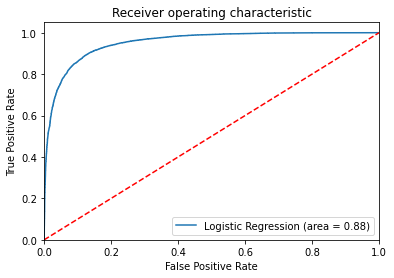

In [43]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Кривая рабочей характеристики приёмника (ROC) является ещё одним популярным инструментом, используемым с бинарными классификаторами. Пунктирная линия представляет ROC-кривую полностью случайного классификатора. Хороший классификатор остаётся от неё максимально далеко (по направлению к верхнему левому углу).

## Модель LinearSVM

In [54]:
# TASK 1.1: create TfidfVectorizer object and fit it on out training set texts
# Our implementation is 2 lines
# YOUR CODE STARTS
vectorizer = TfidfVectorizer()
values = vectorizer.fit_transform(text_dataset['train']['text'])
# YOUR CODE ENDS

X_train, y_train = convert_dataset(text_dataset['train'])
X_test, y_test = convert_dataset(text_dataset['test'])

In [55]:
model = SVC()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.8872


## Использование N-грамм в TF-IDF

In [45]:
vectorizer = TfidfVectorizer(ngram_range=(1,4), max_features=50000)
values = vectorizer.fit_transform(text_dataset['train']['text'])
X_train, y_train = convert_dataset(text_dataset['train'])
X_test, y_test = convert_dataset(text_dataset['test'])

In [46]:
model = LogisticRegression().fit(X_train, y_train)

In [47]:
predictions = model.predict(X_test)

In [48]:
# note that we can use vector operations, because we deal with numpy tensors
accuracy = (predictions == y_test).mean()
accuracy

0.89428

In [ ]:
### Выводы

У линейных моделей: логистической и SVM - модели точность прогноза примерно одинаковая
  
